In [6]:
import librosa
import math
import librosa.display as display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.mixture import GaussianMixture
import fastaudio.core.signal as fcs
import GetTranscription


In [7]:
lvpath ="E:\Datasets\Voice\Librivox\dev\LibriSpeech\dev-clean"
libri_train ="E:\Datasets\Voice\LibriSpeech"
mcvpath ="E:\Datasets\Voice\Mozilla Common Voice\en\cv-corpus-6.1-2020-12-11\en"
single_word = "./samples/but bowl.wav"

In [8]:
clips =fcs.get_audio_files(libri_train)
len(clips)

28539

E:\Datasets\Voice\LibriSpeech\train-clean-100\248\130652\248-130652-0020.flac
YOU NEED NOT GIVE YOURSELF MUCH TROUBLE PERHAPS BUT SOME FORMS MUST BE GONE THROUGH BEFORE A MAN CAN MARRY A MILLION VERY LIKELY BUT I AM NOT GOING TO MARRY A MILLION
(265482,)


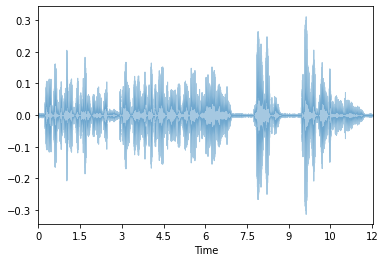

In [9]:
clip= clips[6576]
audio,sr = librosa.load(clip)
print(clip)
print(GetTranscription.get_file_transcript(clip))
print(audio.shape)
librosa.display.waveplot(audio,sr=sr,alpha=0.4)
ipd.Audio(audio[:],rate=sr)

In [10]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [11]:
# extract feautres as suggested by "Segmentation of Speech Signal into Phonemes using Two-Level GMM Tokenization"
def zero_energy(audio):
    # spectral bandwith every 10ms
    spectral_bandwidth = librosa.feature.spectral_centroid(audio, sr=sr, hop_length=220)[0]
    acr = librosa.autocorrelate(spectral_bandwidth)
    
    
    #resample into 10ms chunks
    audio= librosa.resample(y=audio, orig_sr=sr, target_sr=100)
    #extract energy per frame    
    energy = normalize(librosa.pcen(audio,sr=100))
    #replace empty values with zero
    np.nan_to_num(energy, copy=False, nan=0.0, posinf=None, neginf=None)
   
    #extract zero crossings rate
    zcr = librosa.zero_crossings(audio,frame_length=220)
    np.nan_to_num(zcr, copy=False, nan=0.0, posinf=None, neginf=None)
    
  
    return np.c_[energy,zcr,acr[0:len(energy)]]
    
    

In [14]:
# extract feautres as suggested by "Segmentation of Speech Signal into Phonemes using Two-Level GMM Tokenization"



##
###
##try rms energy normalized instead of per channel energy
###

def zero_energy_l(audio,sr):
    # spectral bandwith every 10ms
    
    s= librosa.autocorrelate(audio)
    acr=normalize(librosa.feature.spectral_bandwidth(s,hop_length=220)[0])
    zcr = librosa.feature.zero_crossing_rate(audio, hop_length=220)[0]
       
    #resample into 10ms chunks
    audio= librosa.resample(y=audio, orig_sr=sr, target_sr=100)
    #extract energy per frame    
    energy = librosa.pcen(audio,sr=100)
    energy_norm = normalize(energy)
    #replace empty values with zero
    np.nan_to_num(energy, copy=False, nan=0.0, posinf=None, neginf=None)
    
    return librosa.util.stack([energy, zcr[0:len(energy)],acr[0:len(energy)] ], axis=-1)  
    

In [65]:
EM = GaussianMixture(n_components=3)
counter = 0 
for x in clips[100:15100]:
    print (counter , x)
    clip,sr= librosa.load(x, sr= 22000)
    s = zero_energy_l(clip,sr)
    EM.fit(s)   
    counter +=1

0 E:\Datasets\Voice\LibriSpeech\train-clean-100\103\1241\103-1241-0042.flac


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2218: RuntimeWarning: invalid value encountered in log1p
  S_out = (bias ** power) * np.expm1(power * np.log1p(S * smooth / bias))


1 E:\Datasets\Voice\LibriSpeech\train-clean-100\103\1241\103-1241-0043.flac


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))


2 E:\Datasets\Voice\LibriSpeech\train-clean-100\1034\121119\1034-121119-0000.flac


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))


3 E:\Datasets\Voice\LibriSpeech\train-clean-100\1034\121119\1034-121119-0001.flac


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))


4 E:\Datasets\Voice\LibriSpeech\train-clean-100\1034\121119\1034-121119-0002.flac


KeyboardInterrupt: 

In [18]:
zero_energy_l(audio,sr)


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2218: RuntimeWarning: invalid value encountered in log1p
  S_out = (bias ** power) * np.expm1(power * np.log1p(S * smooth / bias))


array([[0.07651009, 0.03857422, 0.45337239],
       [0.22542982, 0.05273438, 0.45231759],
       [0.        , 0.05712891, 0.44806314],
       ...,
       [0.        , 0.09765625, 0.2449574 ],
       [0.28124183, 0.11523438, 0.20076638],
       [0.22493722, 0.11376953, 0.16765939]])

In [196]:
librosa.feature.zero_crossing_rate(audio, hop_length=220)[0].shape

(1207,)

In [1]:
three = zero_energy_l(audio,sr)


NameError: name 'zero_energy_l' is not defined

In [41]:

s= librosa.autocorrelate(audio)
sb =librosa.feature.spectral_bandwidth(s,hop_length=220)[0]
sb

array([1520.29942558, 1518.9409966 , 1513.46188363, ..., 1133.20135814,
       1131.46651581, 1151.09314049])

In [69]:
print(librosa.feature.zero_crossing_rate(audio,hop_length=220)[0])

[0.03857422 0.05273438 0.05712891 ... 0.10839844 0.09375    0.08056641]


In [68]:
print(librosa.feature.zero_crossing_rate(audio)[0])

[0.03857422 0.05908203 0.06982422 0.07470703 0.07666016 0.0625
 0.06689453 0.07226562 0.05712891 0.06347656 0.07128906 0.07568359
 0.06640625 0.05810547 0.05615234 0.06542969 0.08447266 0.10644531
 0.09912109 0.08007812 0.05859375 0.04199219 0.05078125 0.06396484
 0.08740234 0.10986328 0.12402344 0.11962891 0.10253906 0.07373047
 0.04492188 0.09521484 0.11376953 0.13720703 0.14990234 0.10351562
 0.10253906 0.10839844 0.11425781 0.11328125 0.11669922 0.1328125
 0.20703125 0.30126953 0.38671875 0.45947266 0.42724609 0.33056641
 0.23583984 0.13574219 0.08544922 0.07958984 0.10400391 0.14648438
 0.18164062 0.19824219 0.16259766 0.10888672 0.07958984 0.07275391
 0.07910156 0.08837891 0.07714844 0.12255859 0.21044922 0.28320312
 0.38183594 0.41357422 0.39208984 0.32763672 0.24169922 0.15820312
 0.08642578 0.06396484 0.04492188 0.03857422 0.06054688 0.07568359
 0.07568359 0.06542969 0.04931641 0.05761719 0.07226562 0.09472656
 0.11328125 0.11279297 0.12451172 0.13330078 0.12939453 0.13085938


In [168]:
print(three)
three.shape

[[-0.00318086  0.05908203  0.76713216]
 [ 0.          0.07080078  0.76903166]
 [ 0.28482472  0.08251953  0.77683328]
 [ 0.          0.09765625  0.80366078]
 [ 0.          0.11425781  0.88446972]
 [ 0.29593528  0.12695312  0.96307114]
 [ 0.          0.14501953  1.        ]
 [ 0.          0.18017578  0.99493132]
 [ 0.287223    0.21582031  0.95778646]
 [ 0.28800886  0.25732422  0.90131075]
 [ 0.          0.29736328  0.84259596]
 [ 0.28302342  0.33984375  0.80455264]
 [ 0.28588543  0.36962891  0.7771483 ]
 [ 0.          0.40722656  0.72491539]
 [ 0.          0.44677734  0.63757319]
 [ 0.          0.46484375  0.55599252]
 [ 0.          0.46337891  0.50072935]
 [ 0.2868448   0.43017578  0.47491267]
 [ 0.28184914  0.39257812  0.47404958]
 [ 0.          0.34765625  0.47429236]
 [ 0.          0.30517578  0.4592766 ]
 [ 0.          0.26513672  0.40589399]
 [ 0.          0.22363281  0.33167108]
 [ 0.          0.1796875   0.23190853]
 [ 0.28744444  0.13818359  0.12630731]
 [ 0.          0.09521484

(33, 3)

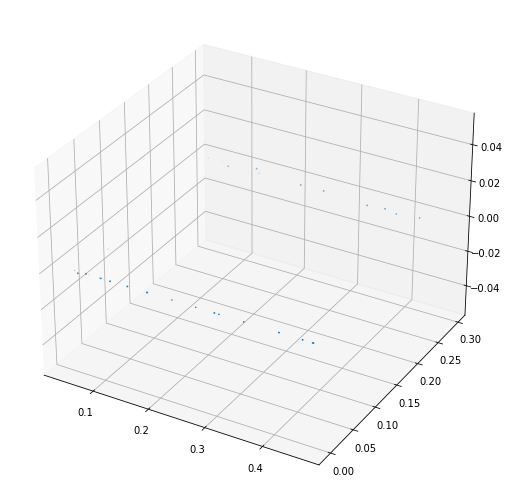

In [169]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection='3d')
plt.scatter(three[:,1],three[:,0],three[:,2])

In [170]:
model = sklearn.cluster.KMeans(n_clusters=3)
labels = model.fit_predict(three)
print(labels)

[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 2.000 2.000 2.000 2.000 2.000 2.000 2.000 2.000 2.000 2.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000]


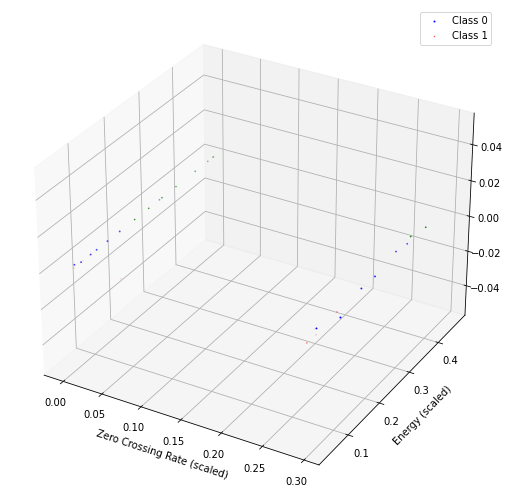

In [171]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection='3d')
plt.scatter(three[labels==0,0], three[labels==0,1],three[labels==0,2], c='b')
plt.scatter(three[labels==1,0], three[labels==1,1],three[labels==1,2], c='r')
plt.scatter(three[labels==2,0], three[labels==2,1],three[labels==2,2], c='g')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

In [7]:
x= EM.predict(three)

NameError: name 'EM' is not defined

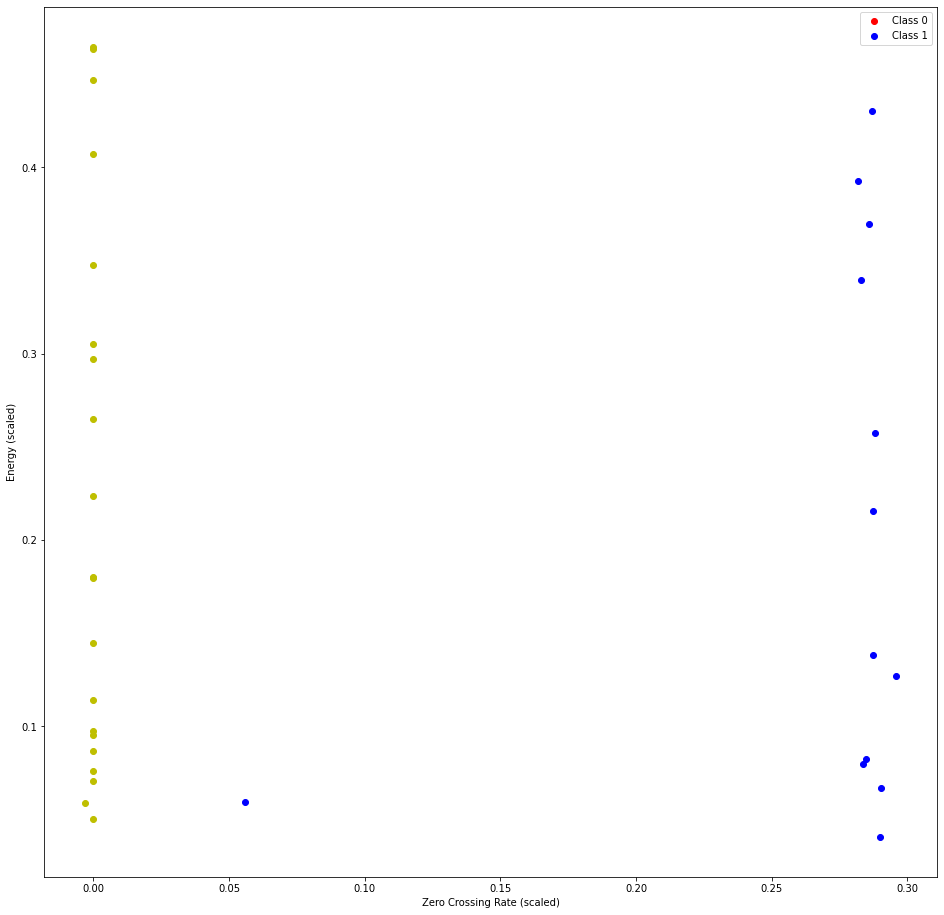

In [177]:
fig = plt.figure(figsize=(16,16))
#ax = fig.add_subplot(projection='3d')
plt.scatter(three[x==0,0], three[x==0,1], c='r')
plt.scatter(three[x==1,0], three[x==1,1], c='b')
plt.scatter(three[x==2,0], three[x==2,1], c='y')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

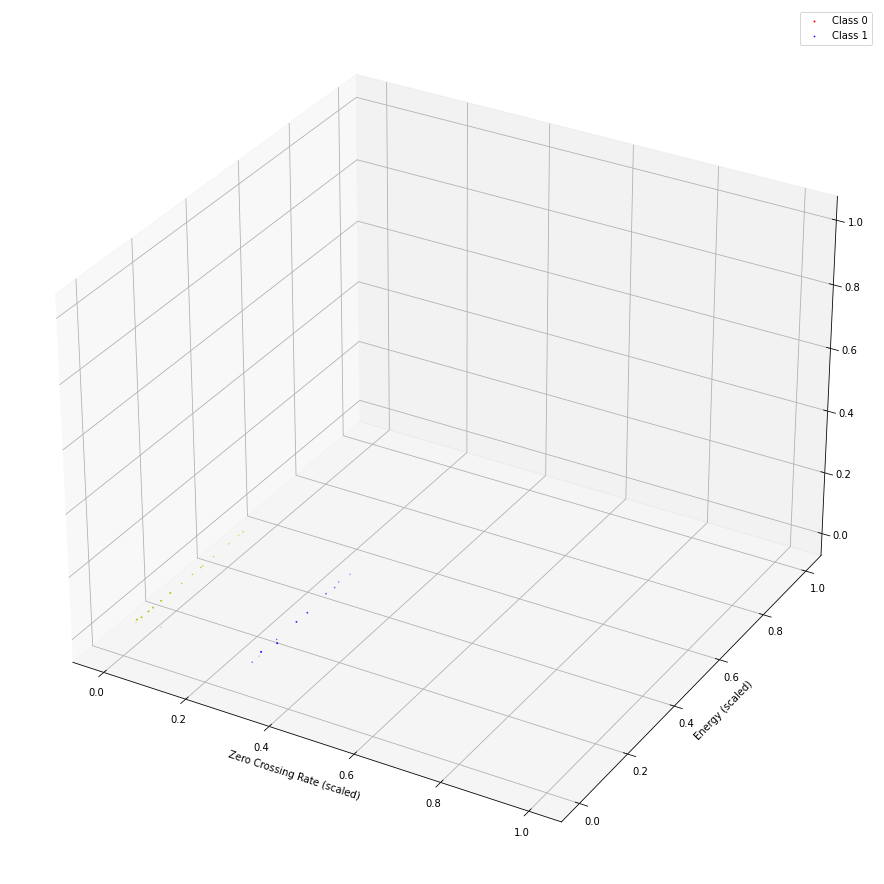

In [174]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')
plt.scatter(three[x==0,0], three[x==0,1],three[x==0,2], c='r')
plt.scatter(three[x==1,0], three[x==1,1],three[x==1,2], c='b')
plt.scatter(three[x==2,0], three[x==2,1],three[x==2,2], c='y')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

In [147]:
normalize(three[:,1])
np.argmax(three[:,0])
np.set_printoptions(formatter={'int': lambda x: "{0:0.3f}".format(x)})
print(three[:,0])

[0.07663864 0.22762779 0.         ... 0.         0.27985454 0.        ]


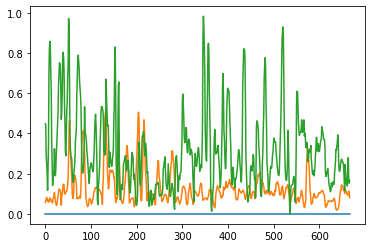

In [107]:
plt.plot(three[x==2,:])

In [178]:
print(len(x))
print(x)
x[0:150]

33
[2.000 2.000 1.000 2.000 2.000 1.000 2.000 2.000 1.000 1.000 2.000 1.000
 1.000 2.000 2.000 2.000 2.000 1.000 1.000 2.000 2.000 2.000 2.000 2.000
 1.000 2.000 2.000 1.000 2.000 1.000 1.000 2.000 1.000]


array([2.000, 2.000, 1.000, 2.000, 2.000, 1.000, 2.000, 2.000, 1.000,
       1.000, 2.000, 1.000, 1.000, 2.000, 2.000, 2.000, 2.000, 1.000,
       1.000, 2.000, 2.000, 2.000, 2.000, 2.000, 1.000, 2.000, 2.000,
       1.000, 2.000, 1.000, 1.000, 2.000, 1.000], dtype=int64)

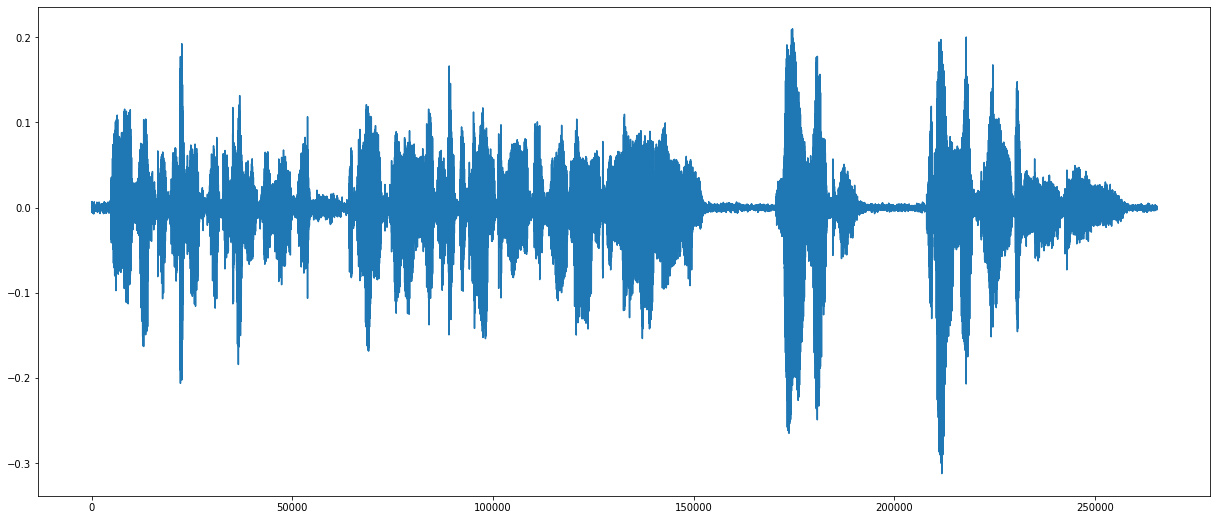

In [215]:
plt.figure(figsize=(21,9))
#raudio= librosa.resample(y=audio, orig_sr=sr, target_sr=100)
plt.plot(audio)

#for s in range(len(x)):
    #if x[s]==2:
    #    plt.axvline(x=s*220, ymin=-0.4, ymax=1, c='r')
    #if x[s]==1:
    #    plt.axvline(x=s*220, ymin=-0.4, ymax=1, c='y')
    #if x[s]==0:
    #    plt.axvline(x=s*220, ymin=-0.4, ymax=1, c='g')

In [236]:
librosa.effects.split(audio, top_db=,  frame_length=2048, hop_length=220)

array([], shape=(0, 2), dtype=int32)

In [51]:
audio.shape

(265482,)

In [197]:
e=audio[19800:27060]

In [217]:
ipd.Audio(audio[3960: 57860],rate=22000)

In [52]:
r = np.correlate(audio, audio, mode='full')[len(x)-1:]

In [46]:
librosa.autocorrelate(audio).shape

(265482,)

In [49]:
r.shape

(530963,)

In [ ]:
plt.figure(figsize=(16,9))
scaled_audio= (sklearn.preprocessing.minmax_scale(audio, axis=0))
audio_range =  np.max(scaled_audio)- np.min(scaled_audio)
mean =np.mean(scaled_audio)
print(audio_range)
y = np.full(len(audio),mean-audio_range*0.01) #audio non silence min
y1 = np.full(len(audio),mean+audio_range*0.01) #audio non silence max
y2 = np.full(len(audio),0.8)
y3 = np.full(len(audio),0.15)
energy = librosa.pcen(audio)
delta_energy = librosa.feature.delta(energy)
delta_energy2 = librosa.feature.delta(delta_energy)

plt.plot(sklearn.preprocessing.minmax_scale(audio, axis=0)) # blue
plt.plot(sklearn.preprocessing.minmax_scale(energy, axis=0)) #yellow
plt.plot(sklearn.preprocessing.minmax_scale(delta_energy, axis=0)) #green
plt.plot(y,c='r')
plt.plot(y1,c='r')
plt.plot(y2,c='g')
plt.plot(y3,c='g')
#plt.plot(sklearn.preprocessing.minmax_scale(delta_energy2, axis=0))




In [183]:
def split_by_energy(audio):
    frames = len(audio)
    # energy per frame
    energy = librosa.pcen(audio)
    #rate of change of energy    
    delta_energy = librosa.feature.delta(energy)
    #rate of change of change of energy
    delta_energy2 = librosa.feature.delta(delta_energy)
    
    
    s_audio= sklearn.preprocessing.minmax_scale(audio, axis=0)
    s_energy = sklearn.preprocessing.minmax_scale(energy, axis=0)
    s_d_energy = sklearn.preprocessing.minmax_scale(delta_energy, axis=0)
    s_d_2_energy = sklearn.preprocessing.minmax_scale(delta_energy2, axis=0)
        
    audio_range =  np.max(s_audio)- np.min(s_audio)
    print(audio_range)
    mean =np.mean(s_audio)
    
    #print("scaled delta energy less than 0.5 ", np.count_nonzero( s_d_energy<0.8))
    #print("scaled audio less than 0.5 ", np.count_nonzero(0.45 >s_audio or s_audio> 0.55))
    
    out = []
    #blue audio
    #yellow energy
    #green de1
    #red de2
    for x in range(frames):
        if s_audio[x] > (mean+0.01) or s_audio[x]< (mean-0.01):
            if s_d_energy[x] < 0.8:
                out.append(x)
    return out

In [184]:
splits = split_by_energy(audio[19800:27060])
print(len(splits))

print(splits)

1.0
93
[379, 380, 381, 382, 435, 436, 478, 585, 690, 795, 899, 900, 1001, 1057, 1058, 1104, 1105, 1166, 1215, 1225, 1321, 1322, 1335, 1336, 1382, 1383, 1384, 1385, 1429, 1430, 1548, 1649, 1769, 1770, 1771, 1780, 1781, 4638, 4700, 4761, 4887, 4899, 5004, 5135, 5256, 5304, 5305, 5306, 5307, 5381, 5382, 5433, 5434, 5639, 5640, 5689, 5690, 5787, 5788, 5901, 5902, 5903, 5904, 5905, 5952, 5953, 5954, 6053, 6172, 6173, 6221, 6222, 6223, 6299, 6356, 6357, 6358, 6432, 6491, 6492, 6493, 6494, 6568, 6569, 6719, 6842, 6843, 7001, 7002, 7055, 7104, 7105, 7106]


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2218: RuntimeWarning: invalid value encountered in log1p
  S_out = (bias ** power) * np.expm1(power * np.log1p(S * smooth / bias))


In [200]:
ipd.Audio(audio[6794:7296],rate=sr)

C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2218: RuntimeWarning: invalid value encountered in log1p
  S_out = (bias ** power) * np.expm1(power * np.log1p(S * smooth / bias))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2218: RuntimeWarning: invalid value encountered in log1p
  S_out = (bias ** power) * np.expm1(power * np.log1p(S * smooth / bias))


1.0


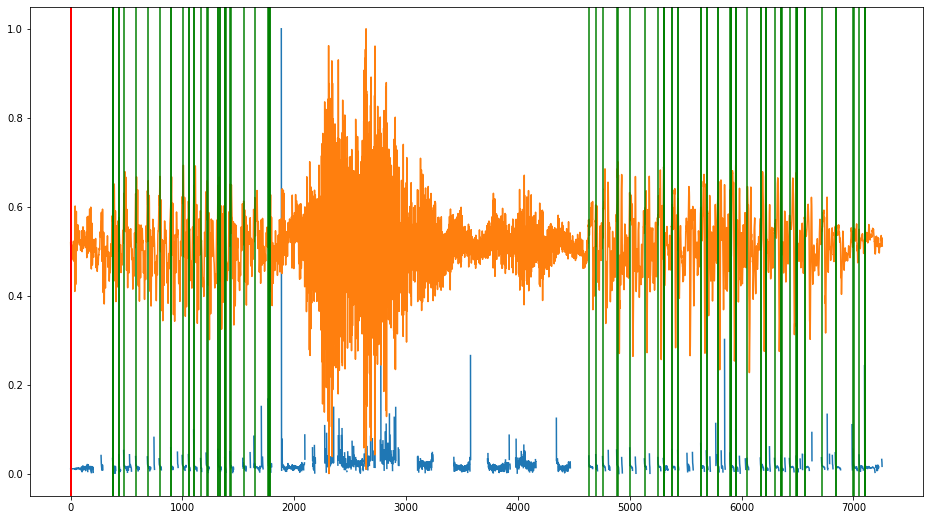

In [187]:
plt.figure(figsize=(16,9))
energy = librosa.pcen(audio[19800:27060])
#plt.plot(audio) #-0.4-0.6
plt.plot(normalize(energy))
plt.plot(normalize(audio[19800:27060]))

for x in split_by_energy(audio[19800:27060]):
    plt.axvline(x=x,ymin= -1,ymax= 1, label=str(x), c='g')
for x in energy:
    if math.sqrt(x**2)<0.02:
        plt.axvline(x=x,ymin= -1,ymax= 1, label=str(x), c='r')
plt.show()

In [253]:
(librosa.feature.rms(audio,hop_length=220)**2)

array([[9.8656410e-06, 1.0028694e-05, 1.0460314e-05, ..., 1.4199197e-06,
        1.4139295e-06, 1.3266895e-06]], dtype=float32)

In [230]:
librosa.power_to_db([np.argmin(db)])

array([21.52288344])

In [254]:
zero_energy_l(audio,sr=sr)[0]

C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\core\spectrum.py:2210: RuntimeWarning: invalid value encountered in log1p
  smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))


array([0.07663864, 0.03857422, 0.45337239])

In [15]:
energy = normalize(librosa.pcen(audio))
delta_energy = normalize(librosa.feature.delta(energy))
delta_energy2 =normalize(librosa.feature.delta(delta_energy))

plt.figure(figsize=(16,9))
plt.plot(audio[:]) #-0.4-0.6
plt.plot(energy) #-0.4-0.6
plt.plot(delta_energy[:]) #0- -30
plt.plot(delta_energy2[:]) #0-2 
plt.show()

print(energy)
print (delta_energy)
#print (min(energy))

NameError: name 'normalize' is not defined

<module 'entropy' from 'C:\\Users\\nerdi\\.conda\\envs\\pyAudio\\lib\\site-packages\\entropy\\__init__.py'>

(1025, 13)


C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


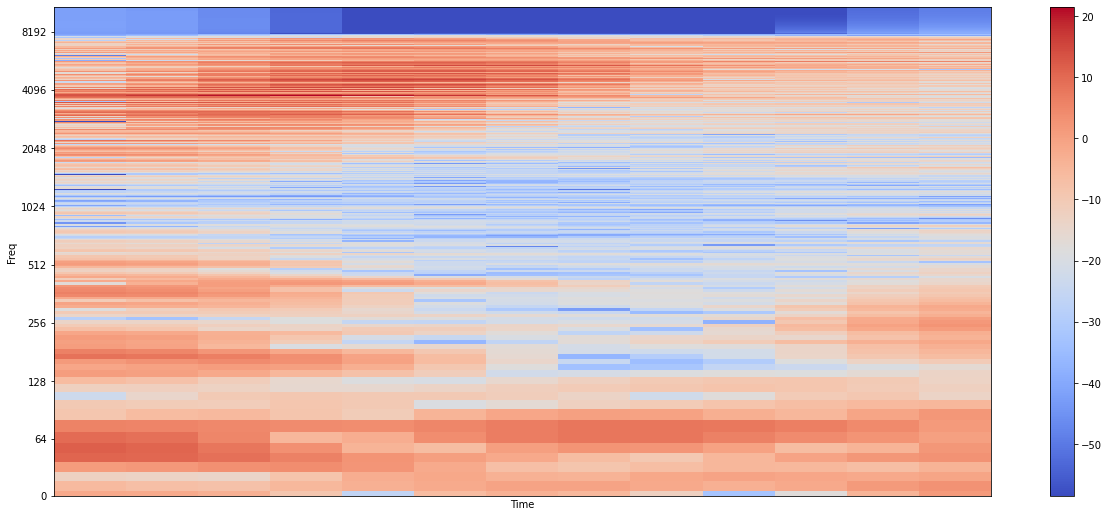

In [246]:
stft = librosa.stft(e[1781:4638], hop_length=220)
print(stft.shape)
spectogram = np.abs(stft)

log_spectogram = librosa.amplitude_to_db(spectogram)
spectogram

plt.figure(figsize=(21,9))
librosa.display.specshow(log_spectogram, y_axis='log')
plt.xlabel("Time")
plt.ylabel("Freq")
plt.colorbar()
plt.show()

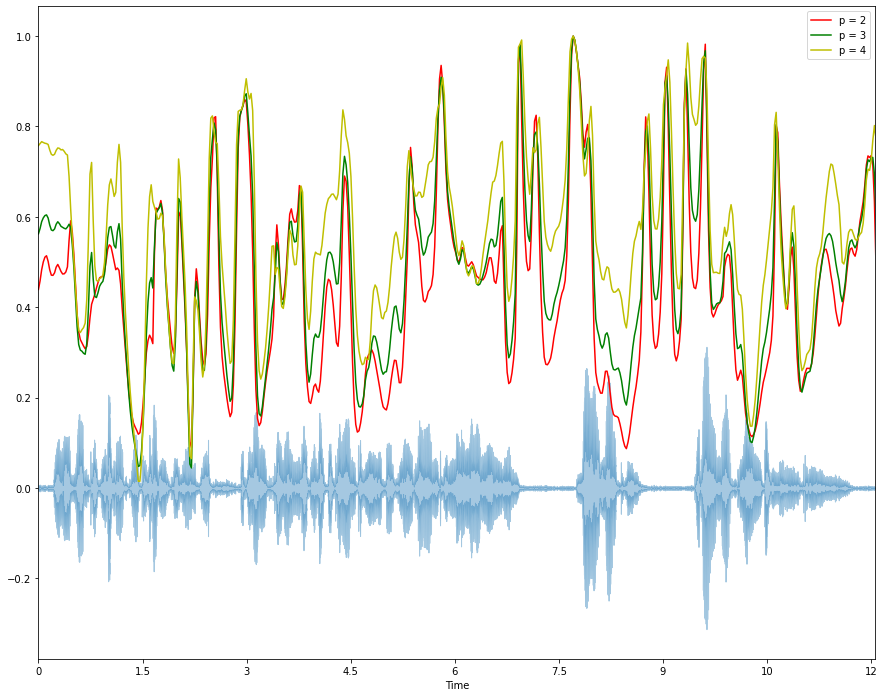

In [153]:
x = audio 
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr, hop_length=220)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, hop_length=220)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3,  hop_length=220)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4,  hop_length=220)[0]
#spectral_bandwidth_5 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=5, hop_length=220)[0]
#spectral_bandwidth_6 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=6, hop_length=220)[0]
plt.figure(figsize=(15, 12))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
#plt.plot(t, normalize(spectral_bandwidth_5), color='b')
#plt.plot(t, normalize(spectral_bandwidth_6), color='pink')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

In [6]:
from joblib import dump, load

In [8]:
dump(EM, 'silenceVoiceClusterEM.joblib') 

NameError: name 'EM' is not defined

In [9]:
EM = load('silenceVoiceClusterEM.joblib') 

In [148]:
a_file= open("test.txt","w")
np.savetxt(a_file, three)
a_file.close()